# 实验一：手动实现卷积神经网络CNN
姓名：王恩泰

学号：21114019

In [15]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image

## 1. 读取数据集

In [16]:
file_dir = ['./车辆分类数据集_small/car', './车辆分类数据集_small/bus', './车辆分类数据集_small/truck']

num_of_class = 3
batch_size = 2
device = torch.device("cpu")

transform_compose = transforms.Compose( # 串联多个transform操作
    [transforms.Resize([8, 8]),  # 统一图形尺寸
     transforms.ToTensor(), # 转成tensor,ToTensor()能够把灰度范围从0-255变换到0-1之间
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # RGB 3个0.5,transform.Normalize()则把0-1变换到(-1,1), image=(image-mean)/std
])

train_tensor = None
test_tensor = None
train_label = []
test_label = []

# 逐个图片处理
for _dix, _dir in enumerate(file_dir):
    files = os.listdir(_dir) # 获取file list
    number_of_img = len(files) # img数量
    for index, img_file in enumerate(files):
        if img_file.endswith('.jpg'):
            img = Image.open(_dir+'/'+img_file)
            img = img.resize((100,100), Image.ANTIALIAS) # 变形
            img = np.array(img)/255
            # print(img.size)
            img_tensor = torch.from_numpy(img)
            img_tensor = img_tensor.permute(2,1,0) # what means?
            if index < (0.8*number_of_img):
                if train_tensor is None:
                    print(img_tensor.shape)
                    train_tensor = img_tensor.unsqueeze(0)
                    print(train_tensor.shape)
                else:
                    train_tensor = torch.cat((train_tensor, img_tensor.unsqueeze(0)), dim=0)
                train_label.append(_dix)
            else:
                if test_tensor is None:
                    test_tensor = img_tensor.unsqueeze(0)
                else:
                    test_tensor = torch.cat((test_tensor, img_tensor.unsqueeze(0)), dim=0)
                test_label.append(_dix)

train_dataset = Data.TensorDataset(train_tensor, torch.LongTensor(train_label)) # train tensor 和 label tensor组合
test_dataset = Data.TensorDataset(test_tensor, torch.LongTensor(test_label))
train_data_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
# , drop_last=False)

# 这个dataloader同时存了X和y
print(train_tensor.shape)
print(test_tensor.shape) # (数量, 通道, H, W)

torch.Size([3, 100, 100])
torch.Size([1, 3, 100, 100])
torch.Size([61, 3, 100, 100])
torch.Size([14, 3, 100, 100])


## 2. 定义卷积运算

In [17]:
# 1. 单通道->单通道
def corr2d(X, K):
    """
    X: input, shape(batch_size, H, W)
    K: 卷积核, shape(k_h, k_w)
    """
    batch_size, H, W = X.shape
    k_h, k_w = K.shape
    Y = torch.zeros(batch_size, H-k_h+1, W-k_w+1).to(device)
    for i in range(Y.shape[1]):
        for j in range(Y.shape[2]):
            Y[:,i,j] = (X[:,i:i+k_h,j:j+k_w]*K).sum() # 卷积后batch_size不变
    return Y

# 2. 多通道->单通道
def corr2d_multi_in(X, K):
    """
    X: input, shape(batch_size, C_in(多通道), H, W)
    K: kernal, shape(C_in, k_h, k_w)
    """
    res = corr2d(X[:,0,:,:], K[0,:,:]) # 第0通道卷积
    for i in range(1, X.shape[1]): # 按通道叠加
        res += corr2d(X[:,i,:,:], K[i,:,:])
    return res

# 3. 多通道->多通道
def corr2d_multi_in_out(X, K):
    return torch.stack([corr2d_multi_in(X, k) for k in K], dim = 1) # 每个卷积核堆一层放在栈中

## 3. 定义（一个）卷积层

In [18]:
class MyConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(MyConv2D, self).__init__()  # 继承父类
        if isinstance(kernel_size, int): # 判断是否为int
            kernel_size = (kernel_size, kernel_size) 
        # 初始化参数
        self.weight = nn.Parameter(torch.randn((out_channels, in_channels) + kernel_size)) # 这里加号当乘号来用，有几层
        self.bias = nn.Parameter(torch.randn(out_channels, 1, 1))
        # 这里bias为什么后两项是1，1. 另外是否卷积层是线性层？
        
    def forward(self, x): # 该层向前计算
        return corr2d_multi_in_out(x, self.weight) + self.bias

## 4. 定义整个卷积过程

In [19]:
class MyConvModule(nn.Module):
    def __init__(self): # 定义函数
        super(MyConvModule, self).__init__()
        self.conv = nn.Sequential(
            MyConv2D(in_channels=3, out_channels=32, kernel_size=3), # 输出为什么是32通道
            nn.BatchNorm2d(32), # 2维的归一化
            nn.ReLU(inplace=True) # 可以覆盖之前的值
        )
        # 加个全连接层用于预测类别
        self.fc = nn.Linear(32, num_of_class)

    def forward(self, X): # 使用上面定义的向前计算
        out = self.conv(X)
        # print(out.shape)
        out = F.avg_pool2d(out, kernel_size=(98,98)) # (98,98)为池化核大小,平均数量为1*1
        # print(out.shape)
        out = out.squeeze() # 将张量batch*32*1*1 变为batch*32
        # print(out.shape)
        out = self.fc(out)
        # print(out.shape)
        return out

## 5. 训练及测试

In [20]:
def train_epoch(net, data_loader, device): # 一个epoch的程序
    net.train() # 训练模式
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0 # 正确分类样本个数
    sample_num = 0 # 样本总数

    # for batch_idx, (x_train, y_train) in enumerate(data_loader):
    x_train, y_train = next(iter(data_loader)) # 取一个batch
    x_train = x_train.to(device).float()
    y_train = y_train.to(device).long() # 因为预测出来是long的
    
    optimizer.zero_grad()
    y_predict = net(x_train)
    print(y_predict)
    print(y_train)
    loss = criterion(y_predict, y_train)
    loss.backward()
    optimizer.step() # 更新参数

    total_loss += loss.item()
    prediction = torch.argmax(y_predict, 1)
    correct += (prediction == y_train).sum().item()
    sample_num += len(prediction)

    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        # for batch_idx, (x_test, y_test) in enumerate(data_loader):
        x_test, y_test = next(iter(data_loader)) # 取一个batch
        x_test = x_test.to(device).float()
        y_test = y_test.to(device).long()
        y_predict = net(x_test)
        loss = criterion(y_predict, y_test)

        total_loss += loss.item()
        prediction = torch.argmax(y_predict, 1)
        correct += (prediction == y_test).sum().item()
        sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

## 6. 主函数

MyConvModule(
  (conv): Sequential(
    (0): MyConv2D()
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
tensor([[-0.3791,  0.2492, -0.3597],
        [-0.3791,  0.2492, -0.3597]], grad_fn=<AddmmBackward>)
tensor([2, 1])
epoch: 0	 train_loss: 0.0334 	train_acc: 0.5000 	test_loss: 0.3831	 test_acc: 0.5000
tensor([[-0.3985,  0.2780, -0.3630],
        [-0.3985,  0.2780, -0.3630]], grad_fn=<AddmmBackward>)
tensor([0, 1])
epoch: 1	 train_loss: 0.0338 	train_acc: 0.5000 	test_loss: 0.2766	 test_acc: 0.5000
tensor([[-0.3832,  0.2677, -0.3415],
        [-0.3832,  0.2677, -0.3415]], grad_fn=<AddmmBackward>)
tensor([2, 2])
epoch: 2	 train_loss: 0.0430 	train_acc: 0.0000 	test_loss: 0.0103	 test_acc: 1.0000


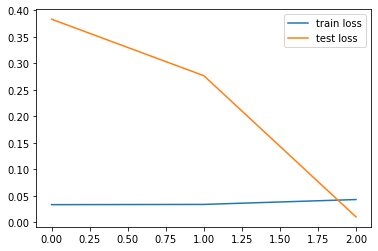

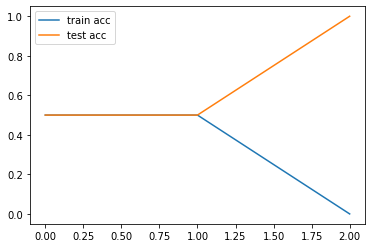

In [21]:
epochs = 3
lr = 0.001
# batch_size = 8
device = torch.device("cpu")

net=MyConvModule().to(device)
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(net, train_data_loader, device)
    test_loss, test_acc = test_epoch(net, test_data_loader, device)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
    print(f"epoch: {epoch}\t train_loss: {train_loss:.4f} \t" f"train_acc: {train_acc:.4f} \t"
         f"test_loss: {test_loss:.4f}\t test_acc: {test_acc:.4f}")         


plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend() 
plt.show()     
plt.plot(train_acc_list, label='train acc')
plt.plot(test_acc_list, label='test acc')
plt.legend() 
plt.show()    